<font color=orange size=6>sound device search</font>

Should show
'
UMA16v2: USB Audio (hw:1,0), ALSA (16 in, 2 out)

📣If can't be used in vscode. use `jupyter notebook` in terminal
'

In [1]:
import sounddevice as sd
print(sd.query_devices())

   0 tegra-hda: HDMI 0 (hw:0,3), ALSA (0 in, 2 out)
   1 tegra-snd-t210ref-mobile-rt565x: - (hw:1,0), ALSA (16 in, 16 out)
   2 tegra-snd-t210ref-mobile-rt565x: - (hw:1,1), ALSA (16 in, 16 out)
   3 tegra-snd-t210ref-mobile-rt565x: - (hw:1,2), ALSA (16 in, 16 out)
   4 tegra-snd-t210ref-mobile-rt565x: - (hw:1,3), ALSA (16 in, 16 out)
   5 tegra-snd-t210ref-mobile-rt565x: - (hw:1,4), ALSA (16 in, 16 out)
   6 tegra-snd-t210ref-mobile-rt565x: - (hw:1,5), ALSA (16 in, 16 out)
   7 tegra-snd-t210ref-mobile-rt565x: - (hw:1,6), ALSA (16 in, 16 out)
   8 tegra-snd-t210ref-mobile-rt565x: - (hw:1,7), ALSA (16 in, 16 out)
   9 tegra-snd-t210ref-mobile-rt565x: - (hw:1,8), ALSA (16 in, 16 out)
  10 tegra-snd-t210ref-mobile-rt565x: - (hw:1,9), ALSA (16 in, 16 out)
  11 UMA16v2: USB Audio (hw:2,0), ALSA (16 in, 2 out)
  12 hdmi, ALSA (0 in, 2 out)
  13 pulse, ALSA (32 in, 32 out)
  14 music, ALSA (0 in, 128 out)
* 15 default, ALSA (32 in, 32 out)


<font color=orange size=6>16 channel input test</font>

In [2]:
import sounddevice as sd
import numpy as np

fs = 48000
channels = 16
duration = 5.0  # record time in seconds
target_name = "UMA16v2"

# search all sound devices
def find_input_device(name_keyword):
    devices = sd.query_devices()
    for i, dev in enumerate(devices):
        if name_keyword.lower() in dev['name'].lower() and dev['max_input_channels'] >= channels:
            print(f"Found matching device at index {i}: {dev['name']}")
            return i
    raise RuntimeError(f"No input device found with keyword '{name_keyword}'")

device_index = find_input_device(target_name)

# start recording
print("Recording...")
data = sd.rec(int(fs * duration), samplerate=fs, channels=channels,
              device=device_index, dtype='float32')
sd.wait()
print("Done.")

# print collected data
print("Mic 0:", data[:10, 0])

Found matching device at index 11: UMA16v2: USB Audio (hw:2,0)
Recording...
Done.
Mic 0: [0.         0.         0.         0.         0.         0.
 0.00032387 0.00032342 0.00034507 0.00031031]


<font color=orange size=6>16 channel input test visualization</font>

Found matching device at index 11: UMA16v2: USB Audio (hw:2,0)
Recording...
Done.


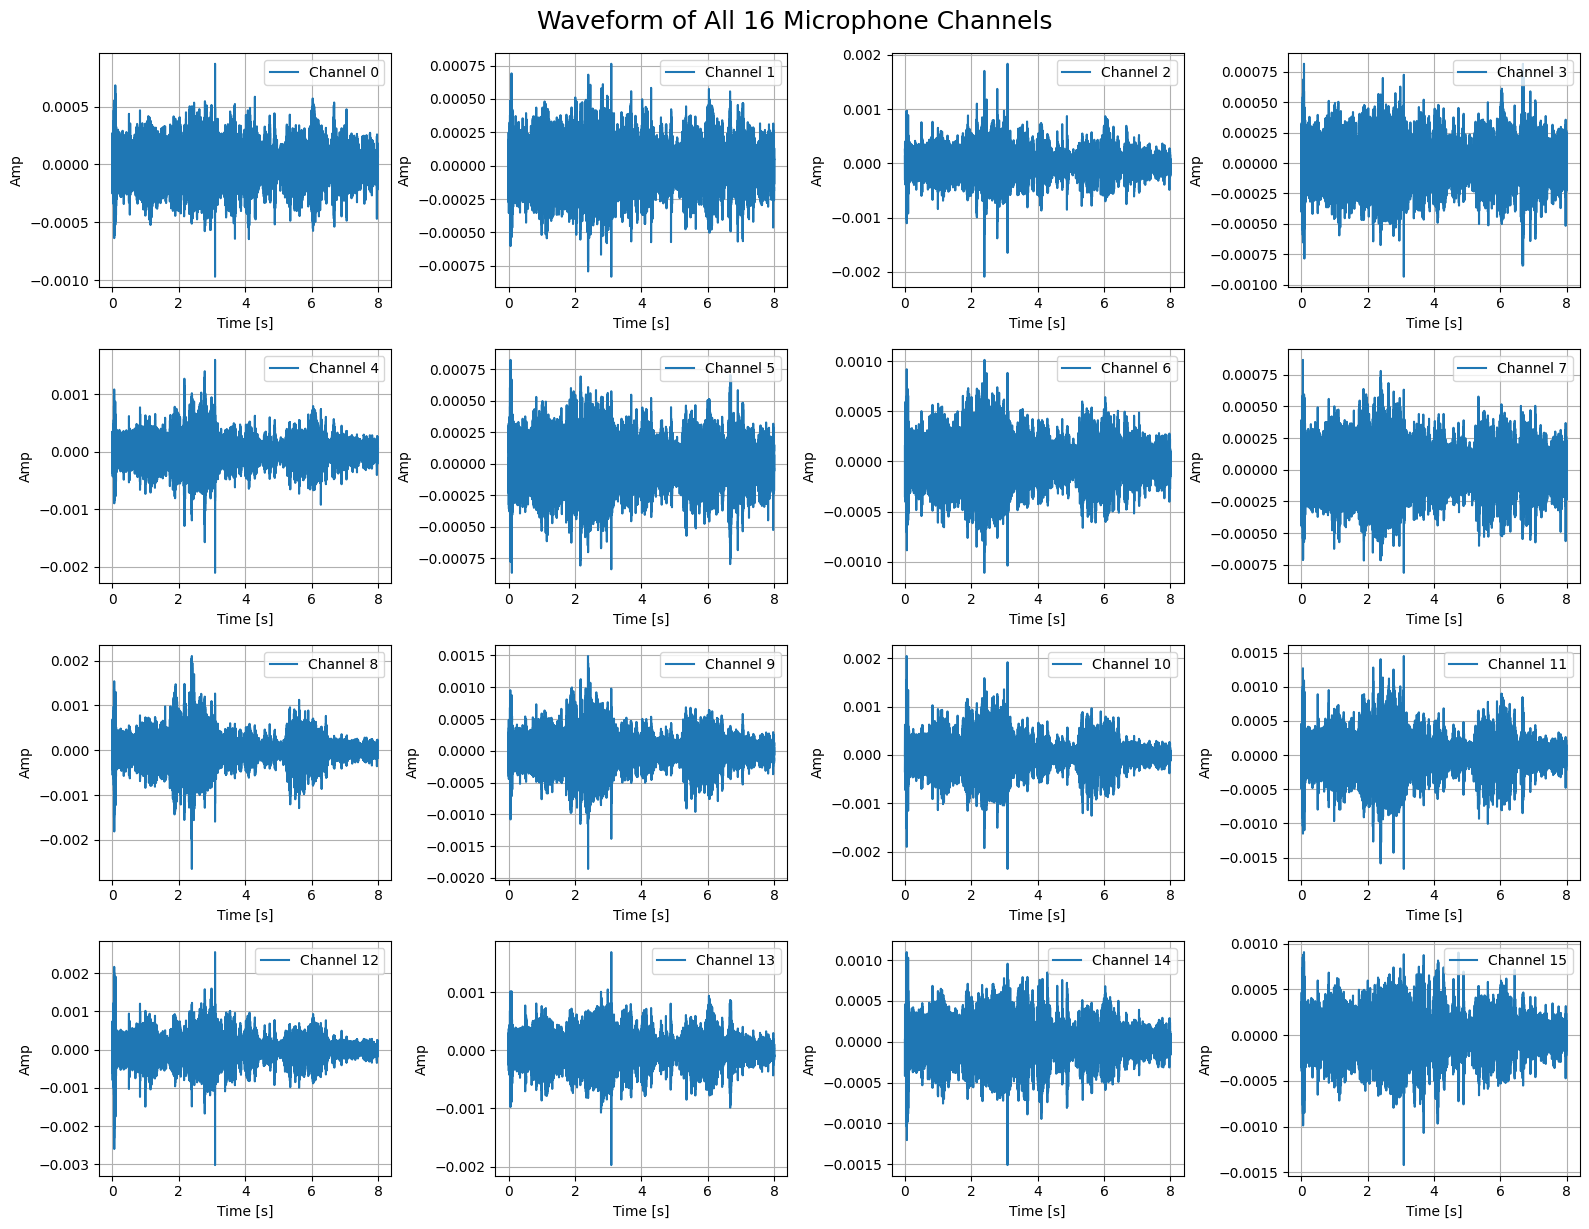

In [4]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import math

fs = 48000
channels = 16
duration = 8.0  # seconds
target_name = "UMA16"

cols = 4
rows = math.ceil(channels / cols)

# Search for input device
def find_input_device(name_keyword):
    devices = sd.query_devices()
    for i, dev in enumerate(devices):
        if name_keyword.lower() in dev['name'].lower() and dev['max_input_channels'] >= channels:
            print(f"Found matching device at index {i}: {dev['name']}")
            return i
    raise RuntimeError(f"No input device found with keyword '{name_keyword}'")

device_index = find_input_device(target_name)

# Record audio
print("Recording...")
data = sd.rec(int(fs * duration), samplerate=fs, channels=channels,
              device=device_index, dtype='float32')
sd.wait()
print("Done.")

time_axis = np.linspace(0, duration, int(fs * duration))

plt.figure(figsize=(16, rows * 3))  
for i in range(channels):
    plt.subplot(rows, cols, i + 1)
    plt.plot(time_axis, data[:, i], label=f'Channel {i}')
    plt.xlabel('Time [s]')
    plt.ylabel('Amp')
    plt.grid(True)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.suptitle('Waveform of All 16 Microphone Channels', fontsize=18, y=1.02)
plt.show()


<font color=orange size=6>pack as ros2</font>

mic_reader_node.py

`ros2 pkg create --build-type ament_python mic_reader --dependencies rclpy std_msgs
`

In [4]:
import rclpy
from rclpy.node import Node
from std_msgs.msg import Float32MultiArray
import sounddevice as sd
import numpy as np

class MicReaderNode(Node):
    def __init__(self):
        super().__init__('mic_reader_node')
        self.publisher_ = self.create_publisher(Float32MultiArray, '/mic_array/audio_raw', 10)
        self.fs = 48000
        self.channels = 16
        self.chunk = int(self.fs * 0.1)  # data/0.1s
        self.device_index = self.find_input_device("UMA16")  # Auto search device index

        self.get_logger().info(f"Using device index: {self.device_index}")
        self.timer = self.create_timer(0.1, self.timer_callback)

    def find_input_device(self, name_keyword):
        devices = sd.query_devices()
        for i, dev in enumerate(devices):
            if name_keyword.lower() in dev['name'].lower() and dev['max_input_channels'] >= self.channels:
                self.get_logger().info(f"Found matching device at index {i}: {dev['name']}")
                return i
        raise RuntimeError(f"No input device found with keyword '{name_keyword}'")

    def timer_callback(self):
        try:
            audio = sd.rec(self.chunk, samplerate=self.fs, channels=self.channels,
                           device=self.device_index, dtype='float32')
            sd.wait()
            msg = Float32MultiArray()
            msg.data = audio.flatten().tolist()
            self.publisher_.publish(msg)
            self.get_logger().info('Published audio chunk')
        except Exception as e:
            self.get_logger().error(f"Error recording audio: {e}")

def main(args=None):
    rclpy.init(args=args)
    node = MicReaderNode()
    rclpy.spin(node)
    node.destroy_node()
    rclpy.shutdown()

ModuleNotFoundError: No module named 'rclpy'